# Motivations

This collection of Jupyter notebook Python cells can load Seaglider data in .hb format.
See `get_sg_data.sh` for an example of how to convert Seaglider data to Hydrobase format.

***


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#=================================================================
# Initialize access to PyFerret.
# -> Pyferret: NOAA, https://ferret.pmel.noaa.gov/Ferret/
# -> ferretmagic: Patrick Brockmann, https://pypi.org/project/ferretmagic/
# -> Running this notebook on the Bowdoin HPC Grid: DJ Merrill
#=================================================================
import sys
sys.path.append('/mnt/local/pyferret/lib/python3.6/site-packages')
import pyferret
pyferret.addenv(FER_DIR='/mnt/local/pyferret', FER_DAT='/mnt/local/FerretDatasets')
pyferret.start(journal=False, quiet=True, unmapped=True)
%load_ext ferretmagic

# Functions

In [2]:
#==========================================
# Function to load glider data for plotting
#==========================================
# This block of code will load the 
# temperature, salinity, and density
# of the seawater the glider observed
# during a the given dive_number.
#
# The outputs of this function are four
# lists: the depth, temperature, salinity,
# and density measured by the glider
# during its dive.
#
# Stefan Gary, 2021
# This code is distributed under the terms
# of the GNU GPL v3 and any later version.
# See LICENSE.txt
#==========================================
def load_glider_data(dive_number):
    # Wipe any previously loaded data and variables in
    # Ferret.  These lines allow for multiple reuse of
    # this function in a given kernel session.
    (e_v, e_m) = pyferret.run('cancel data /all')
    (e_v, e_m) = pyferret.run('cancel variables /all')
    
    # Set a shorter variable name for number of dives.
    # If the glider data has climbs and dives, mult
    # by 2 and subtract 1 to index just the dives.
    dn = dive_number*2 - 1

    # Load the requested data into the notebook
    (e_v, e_m) = pyferret.run(
        'use /mnt/courses/eos2680/sg545/sg545_m03.nc')
    
    # Assign subsets of the data in Ferret - we want to pull out
    # just the data for this particular dive, not the whole mission.
    (e_v, e_m) = pyferret.run('let temp = theta[l='+str(dn)+']')
    (e_v, e_m) = pyferret.run('let salt = salinity[l='+str(dn)+']')
    (e_v, e_m) = pyferret.run('let dens = density[l='+str(dn)+']')
    (e_v, e_m) = pyferret.run('let dept = ctd_depth[l='+str(dn)+']')
            
    # Bring the data from Ferret into the Notebook
    temp = np.squeeze(pyferret.getdata('temp',False)['data'])
    salt = np.squeeze(pyferret.getdata('salt',False)['data'])
    dens = np.squeeze(pyferret.getdata('dens',False)['data'])
    dept = np.squeeze(pyferret.getdata('dept',False)['data'])
    
    # Filter out missing values (usually the placeholder is
    # a very large negative number, 1e-34)
    temp[temp<-4.0] = np.nan
    salt[salt<0] = np.nan
    dens[dens<900] = np.nan

    return dept, temp, salt, dens

# Temperature and salinity sanity plots

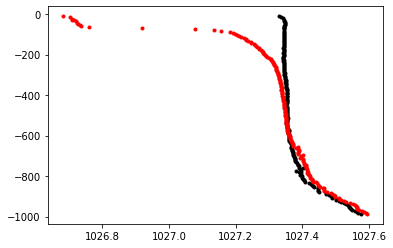

In [3]:
# Load the data from dive 600.
z, t, s, r = load_glider_data(600)

fig, ax = plt.subplots()
ax.plot(r,-1*z,'k.')

z, t, s, r = load_glider_data(1250)
ax.plot(r,-1*z,'r.')

# Maps

[[ 56.692  -7.173 230.   ]
 [ 56.69   -7.177 230.   ]
 [ 56.688  -7.178 228.   ]
 ...
 [ 56.789  -6.822 182.   ]
 [ 56.791  -6.822 185.   ]
 [ 56.794  -6.822 190.   ]]


Text(0.5, 1.0, 'Seaglider track')

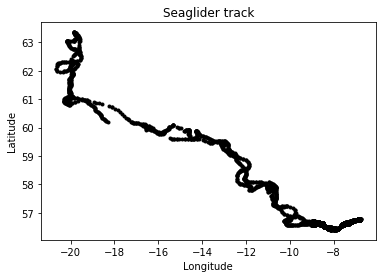

In [11]:
# This command reads the file at the given location
# (in this case, in our class data directory on the
# HPC grid) and puts that data into the python variable
# glider_xyd.  I called it _xyd because it has longitude,
# latitude, and depth.
glider_xyd = np.loadtxt('/mnt/courses/eos2680/sg545/sg545_m03.xyd.csv',delimiter=',')

# And here you can preview the data to make certain it
# is what you think it is.
print(glider_xyd)

# Start by initializing an axis.
# (Later, we can use nearly the same code to
# made side-by-side plots.)
fig, ax = plt.subplots()

# Next plot our data.  You can change the
# line type and color by changing the
# elements in 'k.-'.  Try b, g, r instead
# of k!
ax.plot(glider_xyd[:,1],glider_xyd[:,0],'k.')

# It's always important to label your plots.
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Seaglider track')

Text(0.5, 1.0, 'Seaglider depth soundings')

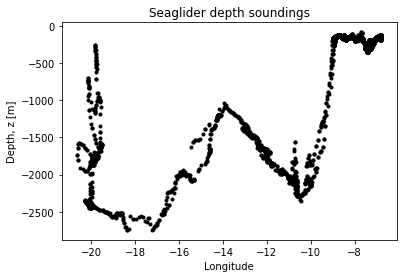

In [6]:
# That was nice, let's get a view of the seafloor
# features that we need to steer around!
fig, ax = plt.subplots()

# Next plot our data.  You can change the
# line type and color by changing the
# elements in 'k.-'.  Try b, g, r instead
# of k!
ax.plot(glider_xyd[:,1],-1.0*glider_xyd[:,2],'k.')
ax.set_xlabel('Longitude')
ax.set_ylabel('Depth, z [m]')
ax.set_title('Seaglider depth soundings')

(50.0, 65.0)

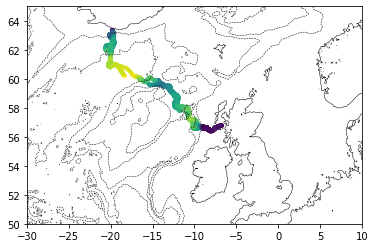

In [7]:
# Cool!  Now, let's put these soundings in the
# context of large scale topographic features.

# Load the global topography data set and store 
#  as a Python variable. (Detailed explanation 
# for why it is this way is optional and below,
# the condensed version is here.)
(error_value, error_message) = pyferret.run(
    'use /mnt/courses/eos2680/ETOPO1/topo_tenthdeg_ice_gline.nc')
lon = np.squeeze(pyferret.getdata('lon1',False)['data'])
lat = np.squeeze(pyferret.getdata('lat1',False)['data'])
topo = np.squeeze(pyferret.getdata('z1',False)['data'])
[y,x] = np.meshgrid(lat,lon)

fig, ax = plt.subplots()
#ax.pcolormesh(x,y,topo,shading='auto',cmap='Spectral')
ax.contour(x,y,topo,
    [-4000,-3000,-2000,-1000,0],
    colors='black',
    linewidths=0.5)

ax.scatter(glider_xyd[:,1],glider_xyd[:,0],10,glider_xyd[:,2])

ax.set_xlim(-30,10)
ax.set_ylim(50,65)



# Example of a deliberate mistake

In [8]:
# Jupyter notebooks will also save error
# messages!  If you have trouble, save
# your notebook as it is and share with
# your instructor or colleague for help
# debugging.  Maybe you can figure out
# what's wrong; look for clues in the
# bottom line of the error message!

copy_of_x = a

NameError: name 'a' is not defined

# Example of plotting directly via Ferret

In the cells above, data is loaded by Ferret, brought into the notebook, and then plotted using matplotlib in the notebook.  You can also plot directly from Ferret.  The reason we're not doing this here is that Ferret's syntax is more complicated (IMO) than Python/matplotlib.  However, as you can see below, Ferret does a great job with automatic labeling and colorbars, etc.  It's worth experimenting with if you have a spare moment, but **not required.**


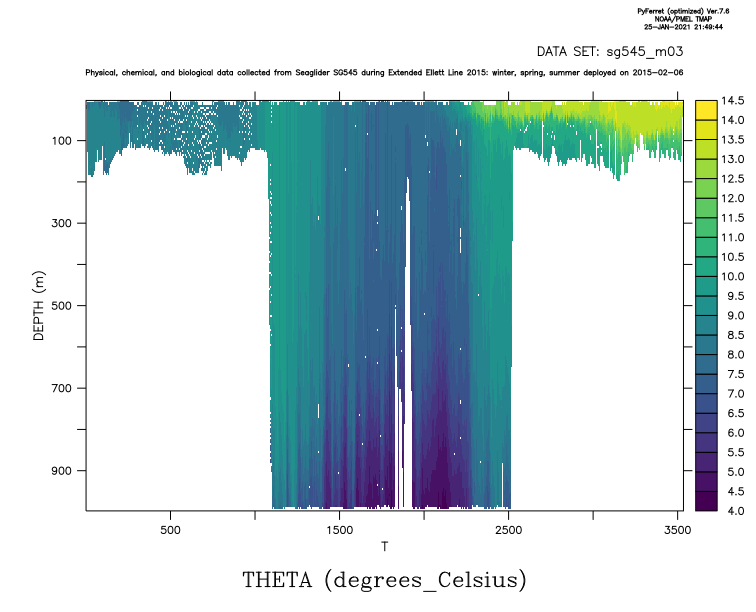

In [9]:
%%ferret
use /mnt/courses/eos2680/sg545/sg545_m03.nc
shade theta
!
!plot /vs /hlimits=34:36 salinity,theta
!plot /l=1199 /vs salinity,theta
!
!plot sigma_theta[l=2500]
!plot /over /color=2 density[l=2500]
!plot /over /color=3 sigma_theta[l=1100]
!plot /over /color=4 density[l=1100]


# More details on the steps for loading data

This code block repeats the code for loading topography except that it breaks each step down so you can see where each bracket and function comes from.  This also is **optional**.

In [10]:
# Load the data set and store as a Python variable
# Python dictionaries are a type of variable that
# stores the data along with its metadata.
#
# The pyferret.getdata commands are accessing data
# by variable name in the given file. If you ever
# need to explore the available variables in a
# NetCDF file, use the following command at the
# *terminal*:
#
# ncdump -h /mnt/courses/eos2680/ETOPO1/topo_tenthdeg_ice_gline.nc
#
# and all the information about the NetCDF file
# will be displayed.
(error_value, error_message) = pyferret.run(
    'use /mnt/courses/eos2680/ETOPO1/topo_tenthdeg_ice_gline.nc')
lon_dict = pyferret.getdata('lon1',False)
lat_dict = pyferret.getdata('lat1',False)
topo_dict = pyferret.getdata('z1',False)

# The "keys" are the names of the entries in the
# dictionary - its pieces.  You can access the values
# associated with a dictionary's keys with
# dict_name['key_name'].
print(topo_dict.keys())

# Put the data into Python arrays
lon = lon_dict['data']
lat = lat_dict['data']
topo = topo_dict['data']

# And you can see the size of the data array
# which is a grid in the x, y, directions but
# the z (depth), time, and other dimensions
# are placeholder dimensions in that they have
# only a length of 1.
print()
print('Array size:')
print(np.shape(topo))

# To cut out these singleton dimensions, use
# the squeeze command:
lon = np.squeeze(lon)
lat = np.squeeze(lat)
topo = np.squeeze(topo)

print()
print('Array size after squeeze:')
print(np.shape(topo))

dict_keys(['title', 'data', 'missing_value', 'data_unit', 'axis_types', 'axis_names', 'axis_units', 'axis_coords'])

Array size:
(3601, 1801, 1, 1, 1, 1)

Array size after squeeze:
(3601, 1801)
